In [1]:
import numpy as np
from numba import jit
from scipy import ndimage
from osgeo import gdal, osr, ogr
import matplotlib.pyplot as plt

plt.style.use('default')

In [2]:
@jit(nopython=True)
def np_mean(neighborhood):
    return np.nanmean(neighborhood)

In [3]:
def lonlat_to_utm(lon, lat):
    if lat < 0:
        return int(32700 + np.floor((180+lon)/6) + 1)
    else:
        return int(32600 + np.floor((180+lon)/6) + 1)

In [4]:
def rowcol_to_xy(row, col, gt):
    x = gt[0] + gt[1] * col + gt[2] * row + gt[1]/2
    y = gt[3] +  gt[4] * col + gt[5] * row + gt[5]/2
    return x, y

In [5]:
in_dem = r"..\Data\N46E009.hgt"
dem_ds = gdal.Open(in_dem)
prj = dem_ds.GetProjection()
srs = osr.SpatialReference(wkt=prj)

gt = dem_ds.GetGeoTransform()
xmin, xpixel, _, ymax, _, ypixel = gt

# Project to UTM zone
utm_epsg = lonlat_to_utm(xmin, ymax)
dem_ds = gdal.Warp("", dem_ds, format="MEM", dstSRS=f'EPSG:{utm_epsg}')

# Get SRS
prj = dem_ds.GetProjection()
srs = osr.SpatialReference(wkt=prj)

# Get the new gt
gt = dem_ds.GetGeoTransform()
xmin, xpixel, _, ymax, _, ypixel = gt
dem_band = dem_ds.GetRasterBand(1)
dem_nodata = dem_band.GetNoDataValue()
width, height = dem_ds.RasterXSize, dem_ds.RasterYSize
xmax = xmin + width * xpixel
ymin = ymax + height * ypixel

# Get the array
dem_array = dem_band.ReadAsArray().astype(float)
dem_array[dem_array == dem_nodata] = np.nan

In [6]:
# Apply a local filter where the resulting value is the mean of the neighborhood 
kernel_size = 21
filtered_dem = ndimage.generic_filter(dem_array, np_mean, size=kernel_size, cval=np.nan)

In [7]:
# Create a Gdal layer from filtered_dem
filtered_dem[np.isnan(filtered_dem)] = dem_nodata
driver = gdal.GetDriverByName("MEM")
dst_ds = driver.Create("", width, height, 1, gdal.GDT_Float32)
dst_ds.GetRasterBand(1).WriteArray(filtered_dem)
dst_ds.GetRasterBand(1).SetNoDataValue(dem_nodata)
dst_ds.SetGeoTransform(gt)
srs = osr.SpatialReference()
srs.ImportFromWkt(prj)
dst_ds.SetProjection(srs.ExportToWkt())

0

In [8]:
# Create a Gdal layer for contours
contour_ds = ogr.GetDriverByName('Memory').CreateDataSource('')
contour_lyr = contour_ds.CreateLayer('contour', 
geom_type = ogr.wkbLineString25D, srs = srs )
field_defn = ogr.FieldDefn('ID', ogr.OFTInteger)
contour_lyr.CreateField(field_defn)
field_defn = ogr.FieldDefn('elev', ogr.OFTReal)
contour_lyr.CreateField(field_defn)

0

In [9]:
# Generate Contours
gdal.ContourGenerate(dst_ds.GetRasterBand(1), 50, 0, [], 
                    1, dem_nodata, contour_lyr, 0, 1)

0

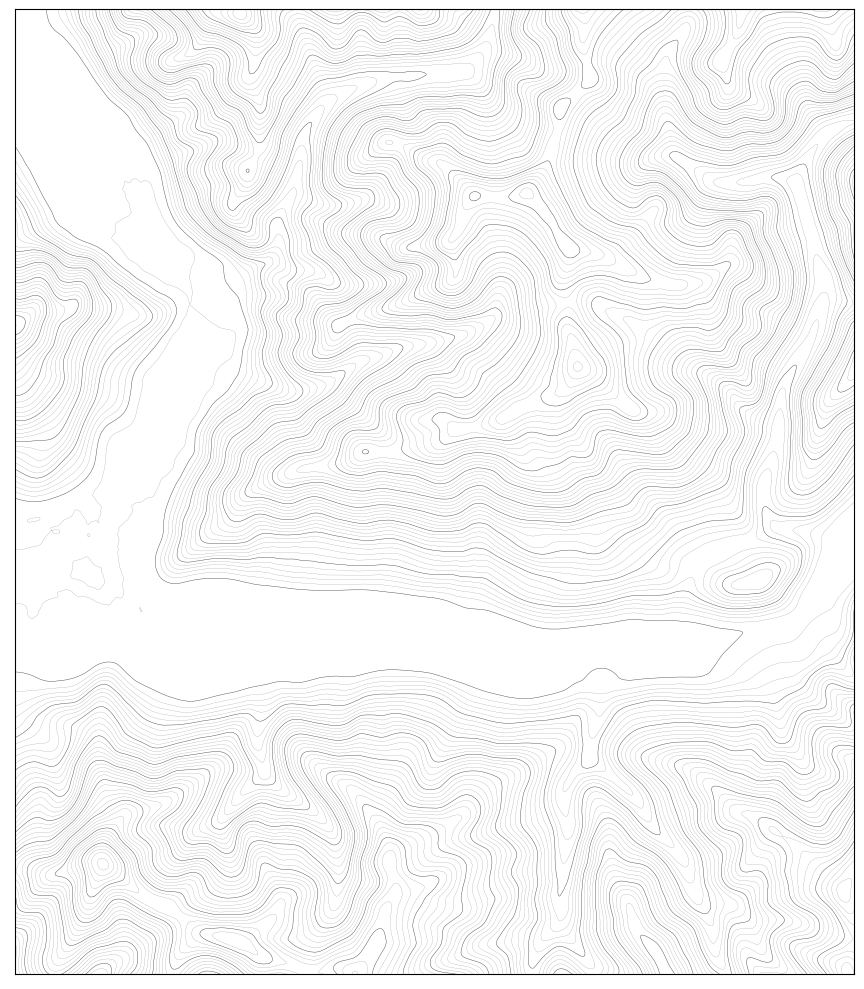

In [10]:
fig, ax = plt.subplots(figsize=(10, 10))
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)
for fc in contour_lyr:
    geom = fc.GetGeometryRef()
    elev = fc.GetField("elev")
    pts = np.array([(pt[0], pt[1]) for pt in geom.GetPoints()])
    if elev % 250 == 0:
        lw = 0.3
    else:
        lw = 0.1
    ax.plot(pts[:, 0], pts[:, 1], lw=lw, c=(0,0,0, 0.75))
ax.set_xlim(530000, 550000)
ax.set_ylim(5102000, 5125000)
ax.set_aspect(True)
plt.tight_layout()
plt.show()